### Solving Max-Cut problem using Quantum Approximate Optimization Algorithm

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator, Batch
from qiskit_ibm_runtime import SamplerV2 as Sampler

##### Simpler example for 5 nodes

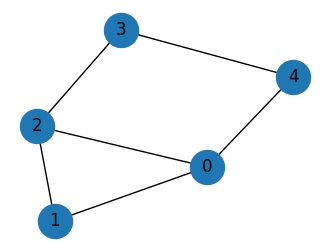

In [12]:
# 1 - generate the graph
n = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
fig, ax = plt.subplots(figsize=(4, 3))
draw_graph(graph, node_size=600, with_labels=True, ax=ax)

In [15]:
# 2 - Reformulate the problem using Quadratic Unconstrained Binary 
# Optimization (QUBO) notation, to represent it as a Hamiltonian
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list
 
 
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])


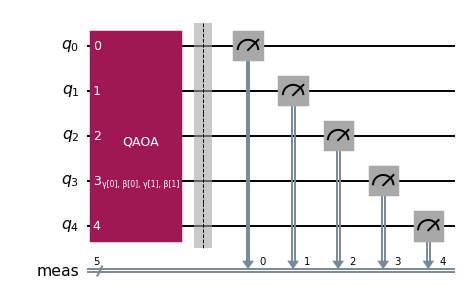

In [19]:
# 3 - Having Hamiltonian, we can map our optimization problem on a quantum circuit
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

print(circuit.parameters)
circuit.draw("mpl", scale=0.7)

qiskit_runtime_service.__init__:WARNING:2025-11-12 07:52:52,202: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: eloza. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-12 07:52:52,896: Loading instance: eloza, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-12 07:52:55,732: Using instance: eloza, plan: open


Least busy backend: ibm_torino
Has 0 pending jobs.


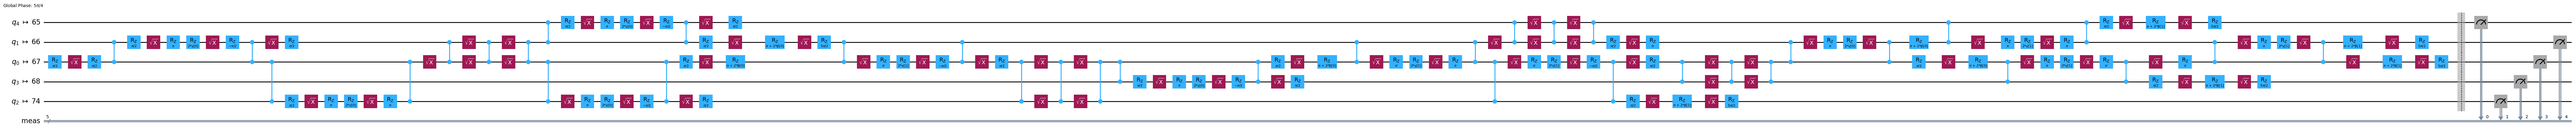

In [21]:
# 4 - Now, lets pick a backend and transpile a problem to its architecture
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(f"Least busy backend: {backend.name}")
print(f"Has {backend.status().pending_jobs} pending jobs.")
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [22]:
# The algorithm will be executed in an iterative optimization loop, which 
# runs a series of circuit evaluations and uses a classical optimizer to find 
# the optimal parameters. To do that we need to:

# 5.1 - Set initial parameters
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [ ]:
# 5.2 - Plug the sampler-based cost function into the SciPy minimizing routine
# to find the optimal parameters. Use a batch mode to run a job in a loop. 

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

objective_func_vals = []  # Global variable
with Batch(backend=backend) as batch:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=batch)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.906493058386794
       x: [ 1.435e+00  2.065e+00  4.149e+00  3.073e+00]
    nfev: 22
   maxcv: 0.0


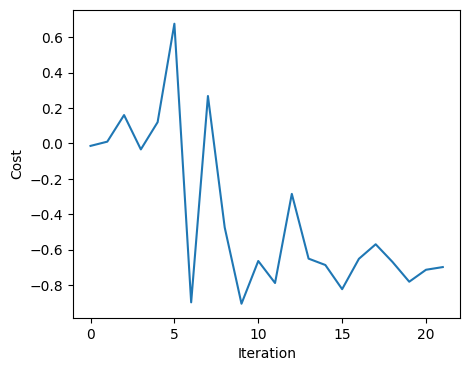

In [30]:
# 5.3 - New parameters for the circuit are
plt.figure(figsize=(5, 4))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [32]:
# 6 - Having found optimized parameters, we can now construct an optimized circuit 

optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

# and run it once again, this time measuring the qubits

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
 
# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
 
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{30: 0.033, 14: 0.0334, 17: 0.0283, 11: 0.0422, 6: 0.0116, 7: 0.0409, 16: 0.0189, 10: 0.0614, 25: 0.0094, 22: 0.0394, 20: 0.0392, 19: 0.0285, 13: 0.0558, 18: 0.0665, 0: 0.0077, 21: 0.061, 24: 0.0375, 5: 0.0284, 8: 0.0215, 27: 0.0316, 3: 0.0088, 9: 0.0378, 4: 0.0377, 29: 0.0266, 15: 0.0196, 23: 0.0233, 31: 0.0102, 2: 0.0335, 1: 0.0353, 26: 0.0284, 12: 0.0326, 28: 0.01}


In [ ]:
# 7 - Postprocessing

# auxiliary functions to: sample most likely bitstring and plot graphs
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    draw_graph(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)
 

# most likely bitstring
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()
 
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 0, 1]


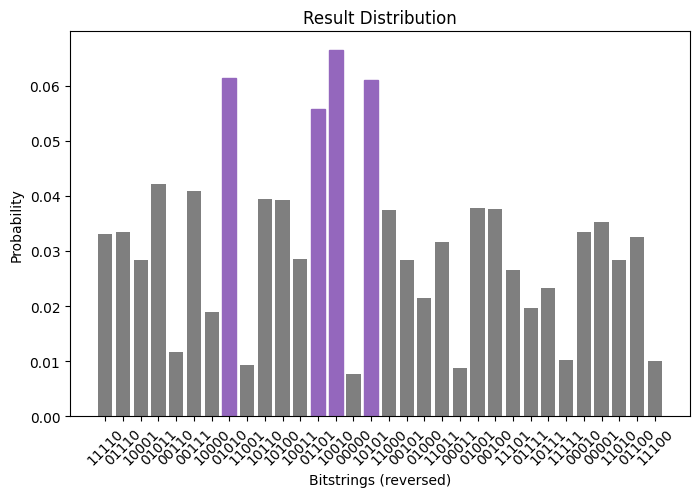

In [ ]:
# 7.1 - Resulting histogram

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

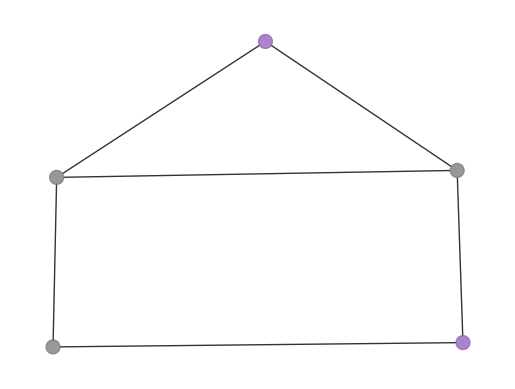

In [ ]:
# 7.2 - final graph

plot_result(graph, most_likely_bitstring)